# Estimating RL parameters using PyMC

Modifying [this notebook](https://github.com/ricardoV94/stats/blob/master/modelling/RL_PyMC.ipynb) to simulate data and estimate parameters for the Machine Game.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import pandas as pd
import seaborn as sns
import scipy

import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

## Data Generation Function

Initial data generation function uses an RL model with only two parameters $\alpha$ and $\beta$. Question for this notebook: can these parameters be recovered successfully by the different estimators (MLE vs. NUTS sampler).

In [ ]:
def generate_data(alpha, beta, n=100, 
                  p_r={'high_var': [.95, .05], 'low_var': [.5,.5]},
                  rs = np.array(([5.0, -495.0],[-5.0, 495.0],[10.0, -100.0],[-10.0, 100.0])),
                  sQ = np.zeros((4, 2))
                 ):
    
    # Need to denote both machine type and action
    
    # Pre-specify machines for each trial in a randomly balanced manner
    if n%4 != 0:
        print("Number of trials is not divisable by 4.\nCreating trials for %s trials."%(str(n-(n%4))))
        n = n-(n%4)
    
    machs = np.array([0,1,2,3])
    machs = np.tile(machs, int(n/4))
    np.random.shuffle(machs)
    
    # Initialize empty array that will be populated in the loop based on Q values
    acts = np.zeros(n, dtype=np.int)
    
    # Generate by coin flip for machine with differing probabilities and outcomes
    rews = np.zeros(n, dtype=np.int)

    # Stores the expected value for each of 4 machines in each trial for each action
    Qs = np.zeros((n, 4, 2))

    # Initialize Q table
    # Denotes expected value of each action
    # Should look like [0, 0] for each machine
    # *** The expected value of not playing should not change from 0! ***
    # Could these initial expected values/beliefs also be estimated from data?
    # E.g. what if kids have more optimistic priors about each machine though they learn at the same rate
    Q = sQ.copy()
    
    for i in range(n):
        
        cur_machine = machs[i]
        
        # Apply the Softmax transformation
        exp_Q = np.exp(np.multiply(beta, Q[cur_machine]))
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice
        a = np.random.choice([0, 1], p=prob_a)
        
        # Simulate reward if machine is played
        if a == 1:
    
            # Before sampling reward determine which variance condition machine is in
            if cur_machine>1:
                cur_p = 'low_var'
            else:
                cur_p = 'high_var'

            # Sample reward for current machine given its reward probs and outcome options
            r = np.random.choice(rs[cur_machine], p = p_r[cur_p]) 
            
            # Update Q table only if the machine is played
            # And only the value of playing NOT of not playing
            Q[cur_machine][a] = Q[cur_machine][a] + alpha * (r - Q[cur_machine][a])
        
        # If the machine is not played then Q remains unchanged and no reward is received
        else:
            r = 0.0

        # Store values
        acts[i] = a
        rews[i] = r
        #Qs[i] = Q.copy()
        Qs[i] = Q

    return machs, acts, rews, Qs

## MLE likelihood functions

In [ ]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    machines, actions, rewards = args

    # Initialize values
    Q = np.zeros((4, 2))
    log_prob_actions = np.zeros(len(actions))

    for t, (m, a, r) in enumerate(zip(machines, actions, rewards)):
        
        # Apply the softmax transformation
        Q_ = Q[m] * beta
        #print('t: %s, m: %s, a: %s, r: %s, Q:[%s, %s]'%(str(t), str(m), str(a), str(r), str(Q[m,0]), str(Q[m, 1])))
        log_prob_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        log_prob_actions[t] = log_prob_action[a]

        # Update the Q values for the next trial
        # Q[a] = Q[a] + alpha * (r - Q[a])
        Q[m][a] = Q[m][a] + alpha * (r - Q[m][a])

    # Return the negative log likelihood of all observed actions
    return -np.sum(log_prob_actions[1:])

In [ ]:
def llik_td_vectorized(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    machines, actions, rewards = args
    n = len(actions)

    # Create a list with the Q values of each trial
    Qs = np.zeros((n, 4, 2), dtype=np.float)
    
    # The last Q values were never used, so there is no need to compute them
    for t, (m, a, r) in enumerate(zip(machines[:-1], actions[:-1], rewards[:-1])):
        Qs[t+1] = Qs[t]
        Qs[t+1, m, a] = Qs[t, m, a] + alpha * (r - Qs[t, m, a])
        Qs[t+1, m, 1-a] = Qs[t, m, 1-a]
        #print('t: %s, m: %s, a: %s, r: %s, Q:[%s, %s]'%(str(t), str(m), str(a), str(r), str(Qs[t,m,0]), str(Qs[t,m, 1])))

    # Apply the softmax transformation in a vectorized way
    idx = list(zip(range(n),machines))
    obs_Qs = [Qs[i] for i in idx]
    Qs_ = np.array(obs_Qs) * beta
    log_prob_actions = Qs_ - scipy.special.logsumexp(Qs_, axis=1)[:, None]

    # Return the log_prob_actions for the observed actions
    log_prob_obs_actions = log_prob_actions[np.arange(n), actions]
    return -np.sum(log_prob_obs_actions[1:]) 

## Generate fake data

In [ ]:
true_alpha = .1
true_beta = 19
n = 120
machines, actions, rewards, all_Qs = generate_data(true_alpha, true_beta, n)

## Parameter recovery with MLE

In [ ]:
x0 = [true_alpha, true_beta]
result = scipy.optimize.minimize(llik_td, x0, args=(machines, actions, rewards), method='BFGS')
print(result)
print('')
print(f'MLE: alpha = {result.x[0]:.2f} (true value = {true_alpha})')
print(f'MLE: beta = {result.x[1]:.2f} (true value = {true_beta})')

### Compute true likelihood of data

In [ ]:
llik_td([true_alpha, true_beta], *(machines, actions, rewards))

In [ ]:
llik_td_vectorized([true_alpha, true_beta], *(machines, actions, rewards))

## Theano and pyMC3 functions

Calculating likelihood of data as an example of using theano tensors 

In [ ]:
def update_Q(machine, action, reward,
             Q,
             alpha):
    Q = tt.set_subtensor(Q[machine, action], Q[machine, action] + alpha * (reward - Q[machine, action]))
    return Q

In [ ]:
# Transform the variables into appropriate Theano objects
machines_ = theano.shared(np.asarray(machines, dtype='int16')) 
actions_ = theano.shared(np.asarray(actions, dtype='int16'))
rewards_ = theano.shared(np.asarray(rewards, dtype='int16'))

alpha = tt.scalar("alpha")
beta = tt.scalar("beta")

# Initialize the Q table
Qs = tt.zeros((4,2), dtype='float64')

# Compute the Q values for each trial
Qs, updates = theano.scan(
    fn=update_Q,
    sequences=[machines_, actions_, rewards_],
    outputs_info=[Qs],
    non_sequences=[alpha])

int_Qs = tt.zeros((1, 4,2), dtype='float64')

Qs = tt.concatenate((int_Qs, Qs), axis=0)

# Apply the softmax transformation
idx = list(zip(range(n),machines)) #list of tuples
obs_Qs = [Qs[tuple(i)] for i in idx]
Qs_ = obs_Qs * beta
log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

# Calculate the negative log likelihod of the observed actions
log_prob_actions = log_prob_actions[tt.arange(actions_.shape[0]), actions_]
neg_log_like = -tt.sum(log_prob_actions[1:])

In [ ]:
theano_llik_td = theano.function(inputs=[alpha, beta], outputs=[neg_log_like], updates = updates)
result = theano_llik_td(true_alpha, true_beta)
float(result[0])

### Theano likelihood calculator

Wrapped up likelihood calculation in function that can be called by pyMC model object

In [ ]:
def theano_llik_td(alpha, beta, machines, actions, rewards, n=120):
    # Transform the variables into appropriate Theano objects
    machines_ = theano.shared(np.asarray(machines, dtype='int16')) 
    actions_ = theano.shared(np.asarray(actions, dtype='int16'))
    rewards_ = theano.shared(np.asarray(rewards, dtype='int16'))
    
    # Initialize the Q table
    Qs = tt.zeros((4,2), dtype='float64')

    # Compute the Q values for each trial
    Qs, updates = theano.scan(
        fn=update_Q,
        sequences=[machines_, actions_, rewards_],
        outputs_info=[Qs],
        non_sequences=[alpha])

    int_Qs = tt.zeros((1, 4,2), dtype='float64')

    Qs = tt.concatenate((int_Qs, Qs), axis=0)

    # Apply the softmax transformation
    idx = list(zip(range(n),machines)) #list of tuples
    obs_Qs = [Qs[i] for i in idx]
    Qs_ = obs_Qs * beta
    log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

    # Calculate the negative log likelihod of the observed actions
    log_prob_actions = log_prob_actions[tt.arange(actions_.shape[0]), actions_]
    return tt.sum(log_prob_actions[1:])

### Alternative theano likelihood calculator 

using a right action probabilities to compare to coin flips using a Bernoilli distribution

In [ ]:
def right_action_probs(alpha, beta, machines, actions, rewards):
    # Transform the variables into appropriate Theano objects
    machines_ = theano.shared(np.asarray(machines, dtype='int16')) 
    actions_ = theano.shared(np.asarray(actions, dtype='int16'))
    rewards_ = theano.shared(np.asarray(rewards, dtype='int16'))
    
    # Initialize the Q table
    Qs = tt.zeros((4,2), dtype='float64')

    # Compute the Q values for each trial
    Qs, updates = theano.scan(
        fn=update_Q,
        sequences=[machines_, actions_, rewards_],
        outputs_info=[Qs],
        non_sequences=[alpha])

    int_Qs = tt.zeros((1, 4,2), dtype='float64')

    Qs = tt.concatenate((int_Qs, Qs), axis=0)

    # Apply the softmax transformation
    idx = list(zip(range(n),machines)) #list of tuples
    obs_Qs = [Qs[i] for i in idx]
    Qs_ = obs_Qs * beta
    log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

    # Calculate the negative log likelihod of the observed actions
    
    return tt.exp(log_prob_actions[:, 1]) 

## Parameter recovery using pyMC3

In [ ]:
actions_ = theano.shared(np.asarray(actions, dtype='int16'))

with pm.Model() as m:
    alpha = pm.Beta('alpha', 1, 1)
    beta = pm.HalfNormal('beta', 10)

    like = pm.Potential('like', theano_llik_td(alpha, beta, machines, actions, rewards))
    
    # The alternative gave some less stable estimates so sticking to the standard for now
    # action_probs = right_action_probs(alpha, beta, machines, actions, rewards)
    # like = pm.Bernoulli('like', p=action_probs, observed=actions_)
    
    tr = pm.sample(draws=2000, chains=1)

In [ ]:
az.plot_trace(tr)

In [ ]:
az.plot_posterior(tr)

## MLE vs NUTS for other combinations of $\alpha$ and $\beta$

### Function run on Sherlock

In [ ]:
# Wrap all the steps pre output into a function
def get_mle_nuts_est(true_alpha, true_beta, n=120, mle_niters = 50):

    # Generate data
    machines, actions, rewards, all_Qs = generate_data(true_alpha, true_beta, n)
    true_llik = llik_td_vectorized([true_alpha, true_beta], *(machines, actions, rewards))

    # MLE estimate starting from true value
    x0 = [true_alpha, true_beta]
    result = scipy.optimize.minimize(llik_td_vectorized, x0, args=(machines, actions, rewards), method='BFGS')
    mle_alpha_ts = result.x[0]
    mle_beta_ts = result.x[1]
    mle_llik_ts = result.fun
    
    # MLE estimate starting from value sampled from prior
    print("Starting MLE iterations with random starts...")
    
    mle_iters = pd.DataFrame([])
    for i in range(mle_niters):
        random_alpha_start = np.random.beta(1,1)
        random_beta_start = scipy.stats.halfnorm(scale=10).rvs()
        x0 = [random_alpha_start, random_beta_start]
        result = scipy.optimize.minimize(llik_td_vectorized, x0, args=(machines, actions, rewards), method='BFGS')
        cur_alpha_est = result.x[0]
        cur_beta_est = result.x[1]
        cur_llik = result.fun
        mle_iters = mle_iters.append({"true_alpha": true_alpha,
                                      "true_beta": true_beta,
                                      'random_alpha_start':random_alpha_start,
                                      'random_beta_starts': random_beta_start,
                                      'cur_alpha_est': cur_alpha_est,
                                      'cur_beta_est': cur_beta_est,
                                      'cur_llik': cur_llik}, ignore_index=True)

    print("Done with MLE iterations with random starts.")
    
    mle_alpha_ave = np.mean(mle_iters.cur_alpha_est)
    mle_alpha_std = np.std(mle_iters.cur_alpha_est)
    mle_beta_ave = np.mean(mle_iters.cur_beta_est)
    mle_beta_std = np.std(mle_iters.cur_beta_est)
    mle_llik_ave = np.mean(mle_iters.cur_llik)
    mle_llik_std = np.std(mle_iters.cur_llik)
    
    # NUTS estimate
    actions_ = theano.shared(np.asarray(actions, dtype='int16'))
    with pm.Model() as m:
        alpha = pm.Beta('alpha', 1, 1)
        beta = pm.HalfNormal('beta', 10)
        like = pm.Potential('like', theano_llik_td(alpha, beta, machines, actions, rewards, n))
        tr = pm.sample()
    
    nuts_alpha_ave = np.mean(tr.alpha)
    nuts_beta_ave = np.mean(tr.beta)
    nuts_alpha_std = np.std(tr.alpha)
    nuts_beta_std = np.std(tr.beta)
    nuts_llik = llik_td_vectorized([nuts_alpha_ave, nuts_beta_ave], *(machines, actions, rewards))

    # Output:
    est_df = pd.DataFrame(data={"true_alpha": true_alpha,
                                "true_beta": true_beta,
                                "true_llik": true_llik,
                                "mle_alpha_ts": mle_alpha_ts,
                                "mle_beta_ts": mle_beta_ts,
                                "mle_llik_ts": mle_llik_ts,
                                "mle_alpha_ave":mle_alpha_ave,
                                "mle_beta_ave": mle_beta_ave,
                                "mle_alpha_std":mle_alpha_std,
                                "mle_beta_std": mle_beta_std,
                                "mle_llik_ave": mle_llik_ave,
                                "mle_llik_std":mle_llik_std,
                                "nuts_alpha_ave": nuts_alpha_ave,
                                "nuts_beta_ave": nuts_beta_ave,
                                "nuts_alpha_std": nuts_alpha_std,
                                "nuts_beta_std": nuts_beta_std,
                                "nuts_llik": nuts_llik}, index=[0])
    
    nuts_posteriors = pd.DataFrame(data={"true_alpha": true_alpha,
                                         "true_beta": true_beta,
                                         "alpha": pd.Series(tr.get_values('alpha')),
                                        "beta": pd.Series(tr.get_values('beta'))})
    
    #return {"est_df": est_df, "mle_iters": mle_iters, "nuts_posteriors": nuts_posteriors}
    return (est_df,  mle_iters, nuts_posteriors)

In [ ]:
true_alpha = .65
true_beta = 1.5
est_df, mle_iters, nuts_posteriors = get_mle_nuts_est(true_alpha, true_beta, mle_niters = 10)

In [ ]:
est_df

### Simulation results

In [2]:
est_df_merged = pd.read_csv('/Users/zeynepenkavi/Dropbox/PoldrackLab/DevStudy_ServerScripts/fit_rl/pymc3_tests/est_df_merged.csv')

In [3]:
est_df_merged = est_df_merged.sort_values(by=['true_alpha', 'true_beta'])

In [4]:
dfa = est_df_merged[["true_alpha", "true_beta", "mle_alpha_ts", "mle_alpha_ave", "nuts_alpha_ave"]]
dfa = dfa.melt(id_vars = ["true_alpha", "true_beta"])
dfa['alpha_dev'] = dfa.true_alpha - dfa.value


In [5]:
dfb = est_df_merged[["true_alpha", "true_beta", "mle_beta_ts", "mle_beta_ave", "nuts_beta_ave"]]
dfb = dfb.melt(id_vars = ["true_alpha", "true_beta"])
dfb['beta_dev'] = dfb.true_beta - dfb.value
dfa['beta_dev'] = dfb.beta_dev
dfb['alpha_dev'] = dfa['alpha_dev']

In [6]:
#Plotting helpers
def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    plt.scatter(x, y, c=c, **kwargs)

def const_line(*args, **kwargs):
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, "--",C='k')

def h_lines(*args, **kwargs):
    x = np.linspace(0, 1, 100)
    plt.hlines(1, 0, 1)
    plt.hlines(0, 0, 1)

#### $\alpha$ estimates

- Removed from figure below
    - What is the realistic $\beta$ range for empirical data? <10 (based on Gershman, 2016).
    - When $\beta = 0$ $\alpha$ is irrelevant because the choice is always a coin flip. So I don't really care if $\alpha$ can't be estimated well in this case   
- Using MLE and the true starting points the $\alpha$ estimates are good when $\beta$ estimates are high but out of bounds or 0 when $\beta$ is smalle.
- Using MLE with random starts from prior distributions the average estimates for $\alpha$ are better and less frequently out of bounds for small $\beta$s. For larger $\beta$s, however, $\alpha$ estimates get stuck on one large value.
- Using NUTS the pattern is similar to MLE with random starts but there are no estimates that are out of the theoretical bounds.


Text(0.5, 0.98, 'Col = true beta')

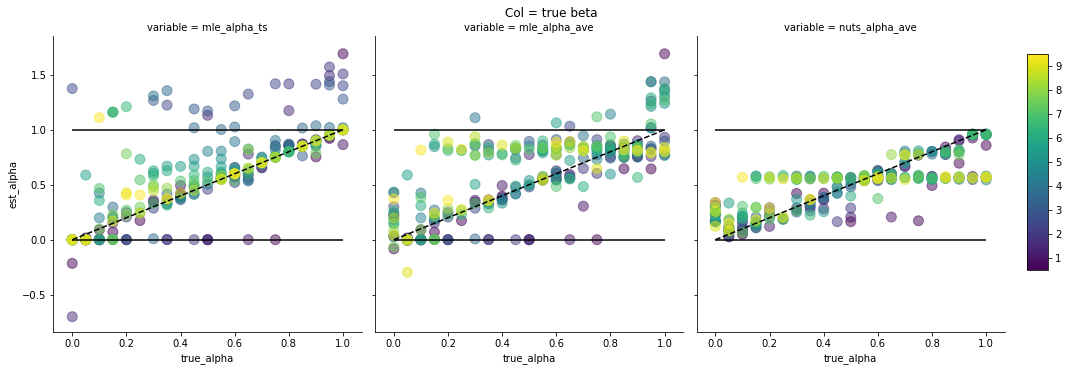

In [12]:
tmp = dfa[(dfa['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()
g = sns.FacetGrid(tmp, col = "variable", height =5)

vmin, vmax = np.min(tmp.true_beta), np.max(tmp.true_beta)

g = g.map(facet_scatter, 'true_alpha', 'value', "true_beta",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

g.map(const_line)

g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)

# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_alpha", "est_alpha")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = true beta")

If we color the $\alpha$ estimates by the raw deviance of $\beta$ instead of true $\beta$ used in data generation (that we would not know in an empirical setting) we find that <font color='red'>**for the range of $\beta$s that we care for the NUTS estimates diverge less from the true values.**

Text(0.5, 0.98, 'Col = beta dev')

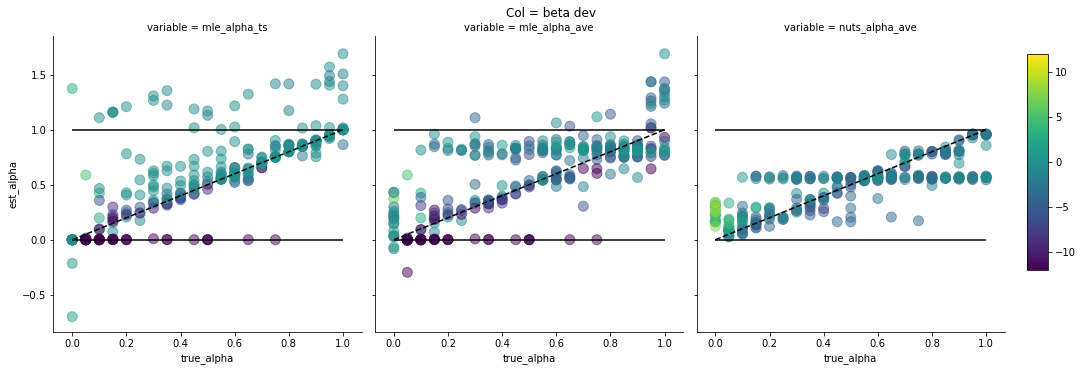

In [15]:
ttmp = dfa[(dfa['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()

g = sns.FacetGrid(tmp, col = "variable", height =5)

#vmin, vmax = np.min(tmp.beta_dev), np.max(tmp.beta_dev)
vmin, vmax = -12, 12

g = g.map(facet_scatter, 'true_alpha', 'value', "beta_dev",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

g.map(const_line)

g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)
# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_alpha", "est_alpha")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = beta dev")

Looking at the raw deviations of $\alpha$ estimates for the three methods we find that the MLE estimates using the true starting values peak most strongly around 0 suggesting better fits.  
However, MLE the true starting value seems like an unfair advantage for this method compared to the others because we would not know the true parameter values for subjects' data in empirical settings.  
NUTS estimates have the second largest peak around 0 and also less extreme deviations overall.

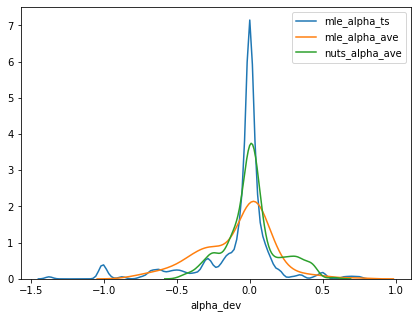

In [19]:
plt.rcParams["figure.figsize"][0] = 7
plt.rcParams["figure.figsize"][1] = 5

tmp = dfa[(dfa['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()

for i in tmp.variable.unique():
    sns.distplot(tmp[(tmp['variable']==i)].alpha_dev, hist = False, label = i)

#### $\beta$ estimates

In [31]:
def const_line(*args, **kwargs):
    x = np.linspace(0, 10, 100)
    plt.plot(x, x, "--",C='k')
    
def h_lines(*args, **kwargs):
    x = np.linspace(0, 10, 100)
    plt.hlines(10, 0, 10)

- MLE with true starts has both the best and the worst $\beta$ estimates (in the range of true $\beta$s we are interested in, i.e. 0<$\beta$<10). For large $\alpha$s $\beta$s are estimated perfectly. For small ones (not all shown below) there are some wildly diverging results
- MLE with random starts has the same problem for small $\alpha$s and worse yet for large $\alpha$s $\beta$s hover around a small range of large and divergent values.
- NUTs estimates are not very good overall either but at least they are not widely out of bounds for any case, including and especially small $\alpha$s and at least for a range of 0<$\beta$<4 it does a better job than MLE with random starts.

Text(0.5, 0.98, 'Col = true alpha')

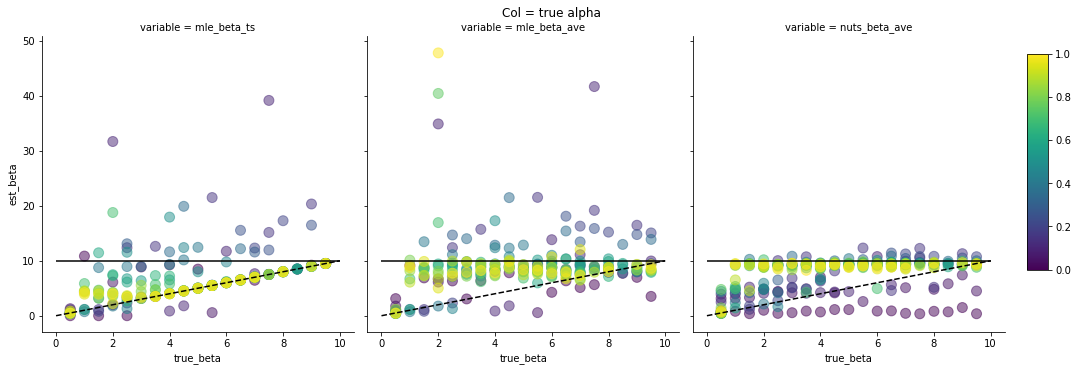

In [34]:
tmp = dfb[(dfb['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()
tmp = tmp[(abs(tmp['value'])<50)].copy()
g = sns.FacetGrid(tmp, col = "variable", height =5)

vmin, vmax = np.min(tmp.true_alpha), np.max(tmp.true_alpha)

g = g.map(facet_scatter, 'true_beta', 'value', "true_alpha",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

g.map(const_line)
g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)

# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_beta", "est_beta")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = true alpha")

When coloring the $\beta$ estimates by divergence of $\alpha$ estimates instead of the true $\alpha$ values we find that in the true $\beta$ range we are interested in $\alpha$ estimates are similarly divergent from their true values.

Text(0.5, 0.98, 'Col = alpha dev')

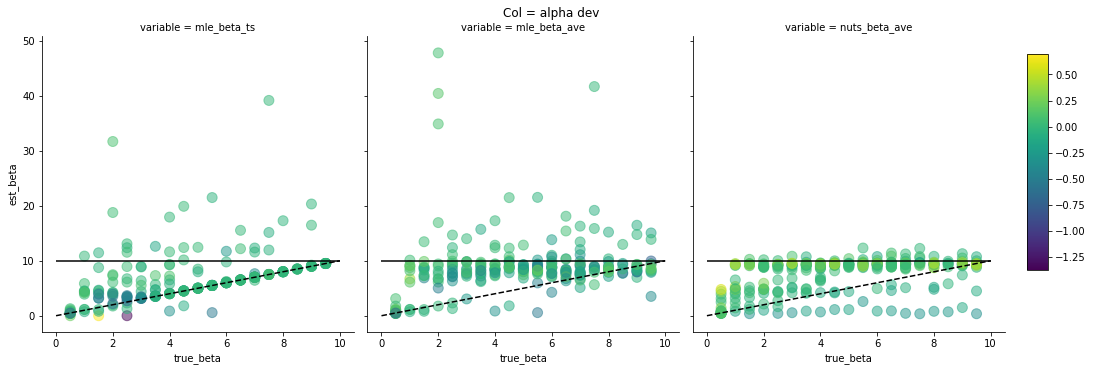

In [36]:
tmp = dfb[(dfb['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()
tmp = tmp[(abs(tmp['value'])<50)].copy()
g = sns.FacetGrid(tmp, col = "variable", height =5)

vmin, vmax = np.min(tmp.alpha_dev), np.max(tmp.alpha_dev)

g = g.map(facet_scatter, 'true_beta', 'value', "alpha_dev",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

g.map(const_line)
g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)

# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_beta", "est_beta")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = alpha dev")

When looking at the distribution of the divergences of the $\beta$ estimates we find that although the MLE estimator with true starts appeared to have the most values on the unit line its wildly off estimates for small true $\alpha$s gives the distributions a very long tail. <font color=red>In the range of acceptable divergences the NUTS estimator outperforms both MLE estimators.

(-20, 10)

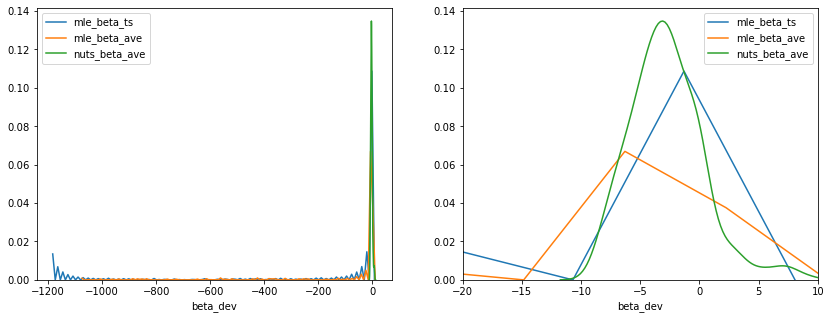

In [41]:
plt.rcParams["figure.figsize"][0] = 14
plt.rcParams["figure.figsize"][1] = 5

tmp = dfb[(dfb['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()

fig, (ax1, ax2) = plt.subplots(1,2)

for i in tmp.variable.unique():
    sns.distplot(tmp[(tmp['variable']==i)].beta_dev, ax = ax1, hist = False, label = i)

for i in tmp.variable.unique():
    sns.distplot(tmp[(tmp['variable']==i)].beta_dev, ax = ax2, hist = False, label = i)
    
ax2.set_xlim(-20, 10)


In [ ]:
g = sns.FacetGrid(dfb, col = "variable", height =5)

vmin, vmax = np.min(dfb.true_alpha), np.max(dfb.true_alpha)

g = g.map(facet_scatter, 'true_beta', 'value', "true_alpha",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)
# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_beta", "est_beta")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = true alpha")

In [ ]:
tmp = dfb[(dfb['value']>=0)].copy()
tmp = tmp[(tmp['value']<20)]

g = sns.FacetGrid(tmp, col = "variable", height =5)

vmin, vmax = np.min(tmp.true_alpha), np.max(tmp.true_alpha)

g = g.map(facet_scatter, 'true_beta', 'value', "true_alpha",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

def const_line(*args, **kwargs):
    x = np.linspace(0, 20, 200)
    plt.plot(x, x, "--",C='k')

g.map(const_line)

#g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)
# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_beta", "est_beta")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = true alpha")

In [ ]:
tmp = dfb[(dfb['value']>=0)].copy()
tmp = tmp[(tmp['value']<20)]

g = sns.FacetGrid(tmp, col = "variable", height =5)

vmin, vmax = np.min(tmp.alpha_dev), np.max(tmp.alpha_dev)

g = g.map(facet_scatter, 'true_beta', 'value', "alpha_dev",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

def const_line(*args, **kwargs):
    x = np.linspace(0, 20, 200)
    plt.plot(x, x, "--",C='k')

g.map(const_line)

#g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)
# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_beta", "est_beta")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = alpha dev")

In [ ]:
plt.rcParams["figure.figsize"][0] = 14
plt.rcParams["figure.figsize"][1] = 5

fig, (ax1, ax2) = plt.subplots(1, 2)

df1 = dfb[(dfb['true_alpha']<=.5)].copy()
df2 = dfb[(dfb['true_alpha']>.5)].copy()

#for i in df1.variable.unique():
# mle_alpha_ts is not realistic because we don't know the true parameter values for subjects' data
# Evaluating mle compared to nuts using the true starting value seems like a an unfair advantage
for i in ["mle_beta_ave", "nuts_beta_ave"]:
    sns.distplot(df1[(df1['variable']==i)].beta_dev, ax=ax1, hist = False, label = i)
    sns.distplot(df2[(df2['variable']==i)].beta_dev, ax=ax2, hist = False, label = i)

ax1.set_title("Small (true) alphas")
ax2.set_title("Large (true) alphas")
ax1.set_xlim(-15, 15)
ax2.set_xlim(-15, 15)

In [ ]:
df1

Next steps:

- ~~Can pyMC recover parameters better for the whole range?~~ 
    - Conclusion: Not necessarily but   
        - it keeps all values within bounds
        - it does not fail in any other way compared to the realistic MLE estimates (i.e. those starting from random values instead of the true values used for data generation)
- Write new or more generalizable data generation functions for different RL models (with more parameters)
- Compare parameter recoverability for at least one more RL model with more parameters 
    - Is recoverability worse for generating processes with more parameters? Not interested in comparing MLE versus NUTS but compare simulation results of NUTS estimates between more simple and complicated processes
- Convert the recoverability function to fitting function

```
 # NUTS estimate
    actions_ = theano.shared(np.asarray(actions, dtype='int16'))
    with pm.Model() as m:
        alpha = pm.Beta('alpha', 1, 1)
        beta = pm.HalfNormal('beta', 10)
        like = pm.Potential('like', theano_llik_td(alpha, beta, machines, actions, rewards, n))
        tr = pm.sample()
    
    nuts_alpha_ave = np.mean(tr.alpha)
    nuts_beta_ave = np.mean(tr.beta)
    nuts_alpha_std = np.std(tr.alpha)
    nuts_beta_std = np.std(tr.beta)
    nuts_llik = llik_td_vectorized([nuts_alpha_ave, nuts_beta_ave], *(machines, actions, rewards))
```
- Fit to one subject's data (using the fitting function created above in fit_rl_cv.py)
- Fit to all subjects' data